### 1D Burger Equation NFTM Simulator using a CNN as the controller.

The Burger equation in 1-dimension is given by:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$


* We want to build a NFTM with a CNN-based update rule for simulating the 1D Burgers equation.

* NFTM architecture:
    * Neural Controller $C$ $\to$ CNN in this case.

    * Continuous memory field (spatial domain) $f_t$: **updates are restricted to neighbour points**.

    * Movable read/write heads that perform **local updates** $h_t$: operate over local regions/patches of this field.

* NFTM architecture for PDEs:
    * The continuous **field** models the spatial domain, a grid representing the solutions $u(x,t)$.

    * The **controller** reads a local patch (neighbourhood) at each time step, computes an update (using CNN), and writes the new value back (updates values in the field). Responsible of updating values + controlling position of read/write heads.

    * At each time step $t$ the CNN controller reads a region, for example: $[u_{i-1}, u_i, u_{i+1}]$ (in 1D) as its input.

    * The CNN uses this input to compute updates by applying a CNN kernel and then writes the updated values back to the same region.

#### Import necessary packages 

In [89]:
# Set environment variables before importing libraries that may initialize OpenMP
# This reduces the chance of multiple OpenMP runtimes (libiomp5md) being initialized
import os
# Unsafe but practical workaround for Windows OpenMP conflicts; keeps the kernel alive.
# If you'd prefer not to use this, see notes below for safer long-term fixes.
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from pathlib import Path
import math
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Debug: show a couple of env vars (optional)
print("KMP_DUPLICATE_LIB_OK=", os.environ.get("KMP_DUPLICATE_LIB_OK"),
      "OMP_NUM_THREADS=", os.environ.get("OMP_NUM_THREADS"),
      "MKL_NUM_THREADS=", os.environ.get("MKL_NUM_THREADS"))


KMP_DUPLICATE_LIB_OK= TRUE OMP_NUM_THREADS= 1 MKL_NUM_THREADS= 1


#### Load training data

We group multiple generated Burgers trajectories by viscosity (ν) and build a single PyTorch Dataset/DataLoader.
Each sample provides:
- initial_field → the field at t=0,
- full_trajectory → a tensor of shape (T,N),
- nu → viscosity metadata (not used by the CNN here).


In [90]:
class BurgersViscosityDataset(Dataset):
    def __init__(self, datasets, viscosities):
        # datasets: list of Tensors, each of shape (num_examples, T, N) for different viscosities
        # viscosities: list or Tensor of corresponding viscosity scalars (floats)
        self.data = []
        self.nu = []

        for data, nu in zip(datasets, viscosities):
            time_instances = data.shape[0]
            self.data.append(data)
            # Create tensor of shape (time_instances, 1) with viscosity nu repeated
            self.nu.append(torch.full((time_instances, 1), nu, dtype=torch.float32))
        
        self.data = torch.cat(self.data, dim=0)  # concatenate all examples
        self.nu = torch.cat(self.nu, dim=0)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Return (initial_field, full_trajectory, viscosity)
        full_trajectory = self.data[idx]          # shape (T, N)
        # print(full_trajectory)
        initial_field = full_trajectory[0, :]     # shape (batch_size, N)
        nu = self.nu[idx]                         # shape (1,)
        return initial_field, full_trajectory, nu


In [91]:
# Functions to load datasets produced by `burger.py` (handles both 'U' and 'u' keys)
def load_burgers_npz_file(file_path):
    data = np.load(str(file_path), allow_pickle=True)
    # prefer 'U' then 'u'
    if 'U' in data.files:
        U = data['U']
    elif 'u' in data.files:
        U = data['u']
    else:
        # pick the first array-like entry that's not metadata
        chosen = None
        for k in data.files:
            if k not in ('x','t','dx','dt','nu','speed','tag'):
                chosen = data[k]
                break
        if chosen is None:
            chosen = data[data.files[0]]
        U = chosen
    U = np.asarray(U)
    # Ensure 2D: (T, N)
    if U.ndim == 1:
        U = U[np.newaxis, :]
    elif U.ndim > 2:
        # try to squeeze leading singleton dims
        U = U.reshape(U.shape[0], -1)
    return torch.tensor(U, dtype=torch.float32)  # shape (T, N)


def _align_array_to_shape(arr, target_T, target_N):
    """Align a (T, N) array to (target_T, target_N) by truncation or padding.
    - Time dimension (axis=0): if shorter, repeat last frame; if longer, truncate.
    - Spatial dimension (axis=1): if shorter, pad by edge values; if longer, truncate.
    """
    arr = np.asarray(arr)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]
    T, N = arr.shape

    # Time alignment
    if T < target_T:
        # repeat last row to pad
        last = arr[-1:]
        pads = np.repeat(last, target_T - T, axis=0)
        arr = np.concatenate([arr, pads], axis=0)
    elif T > target_T:
        arr = arr[:target_T, :]

    # Space alignment
    if arr.shape[1] < target_N:
        pad_width = target_N - arr.shape[1]
        # pad equally both sides if possible, prefer pad on right if odd
        left = pad_width // 2
        right = pad_width - left
        arr = np.pad(arr, ((0, 0), (left, right)), mode='edge')
    elif arr.shape[1] > target_N:
        # center-crop or left-crop? choose center crop
        excess = arr.shape[1] - target_N
        left = excess // 2
        arr = arr[:, left:left+target_N]

    return arr


def collect_generated_burgers(root_dir, align=True):
    """Scan `root_dir` (or its subfolders) for .npz files created by `burger.py`.
    Groups files by their saved `nu` value (if present) and returns:
      - datasets: list of tensors, each with shape (num_examples, T, N)
      - viscosities: list of floats, one per dataset group

    If files within a group have different shapes, they will be aligned (pad/truncate)
    when `align=True`. If align=False and shapes differ, a ValueError is raised.
    """
    from pathlib import Path
    root_dir = Path(root_dir)
    npz_files = sorted([p for p in root_dir.glob('**/*.npz')])
    if len(npz_files) == 0:
        raise FileNotFoundError(f"No .npz files found in {root_dir}")

    groups = {}
    shapes_per_group = {}
    for p in npz_files:
        data = np.load(str(p), allow_pickle=True)
        if 'nu' in data.files:
            nu = float(data['nu'])
        else:
            # fallback default if nu not present
            nu = 0.1
        # prefer 'U' key (saved by burger.py)
        if 'U' in data.files:
            U = np.asarray(data['U'])
        elif 'u' in data.files:
            U = np.asarray(data['u'])
        else:
            # pick first non-meta
            chosen = None
            for k in data.files:
                if k not in ('x','t','dx','dt','nu','speed','tag'):
                    chosen = data[k]
                    break
            if chosen is None:
                chosen = data[data.files[0]]
            U = np.asarray(chosen)

        # ensure 2D
        if U.ndim == 1:
            U = U[np.newaxis, :]
        elif U.ndim > 2:
            U = U.reshape(U.shape[0], -1)

        groups.setdefault(nu, []).append(U)
        shapes_per_group.setdefault(nu, set()).add(U.shape)

    datasets = []
    viscosities = []
    for nu, arrs in groups.items():
        shapes = shapes_per_group[nu]
        if len(shapes) == 1:
            # all same shape -> stack directly
            arrs_np = np.stack(arrs, axis=0)
        else:
            if not align:
                raise ValueError(f"Input arrays for nu={nu} do not have the same shape: {shapes}")
            # align to common shape: choose max T and max N across arrs
            Ts = [a.shape[0] for a in arrs]
            Ns = [a.shape[1] for a in arrs]
            target_T = max(Ts)
            target_N = max(Ns)
            aligned = [_align_array_to_shape(a, target_T, target_N) for a in arrs]
            arrs_np = np.stack(aligned, axis=0)

        datasets.append(torch.tensor(arrs_np, dtype=torch.float32))
        viscosities.append(float(nu))

    return datasets, viscosities


In [92]:
current_dir = Path(os.getcwd()) # get current directory

# Locate the generated dataset folder (search the workspace for the folder name)
gen_dirs = list(current_dir.glob('**/generated_1d_burgers'))
if gen_dirs:
    data_root = gen_dirs[0]
else:
    # fallback: expect generated_1d_burgers next to this notebook
    data_root = Path.cwd() / 'generated_1d_burgers'
    if not data_root.exists():
        raise FileNotFoundError("Could not find 'generated_1d_burgers' in the workspace. Place the dataset under that folder or adjust the path.")

print(f"Using dataset root: {data_root}")

# Use train split if present, otherwise use the folder itself
train_dir = data_root / 'train'
if train_dir.exists():
    use_dir = train_dir
else:
    use_dir = data_root

# Collect datasets grouped by viscosity
datasets, viscosities = collect_generated_burgers(use_dir)
print(f"Found {sum(d.shape[0] for d in datasets)} examples across {len(datasets)} viscosity groups: {viscosities}")

# Build combined dataset and dataloader
combined_dataset = BurgersViscosityDataset(datasets, viscosities)
dataloader = DataLoader(combined_dataset, batch_size=4, shuffle=True)

print("Combined dataset shape:", combined_dataset.data.shape)


Using dataset root: c:\Dev\CentralSupelec\BDRP\NFTM\NFTM_for_Physic\generated_1d_burgers
Found 40 examples across 1 viscosity groups: [0.10000000149011612]
Combined dataset shape: torch.Size([40, 256, 128])


## Hyper-parameters & shape checks

- **History length** HISTORY_LEN = 20: number of past time steps used to predict the next one.
- **Patch radius** r: the spatial neighbourhood radius. The patch length is (2r+1) and must be odd.

We also add a couple of small checks to ensure the CNN’s expected channel count equals HISTORY_LEN and that the output layer produces one scalar per patch.


In [93]:
# ----- HYPERPARAMS À DÉFINIR EN AMONT -----
HISTORY_LEN = 20
r = 1
patch_size = 2 * r + 1  # doit rester cohérent partout

# ----- ASSERTS SUR LES FORMES ET LES PARAMS -----
assert patch_size >= 3 and patch_size % 2 == 1, "patch_size doit être impair >=3"
print("OK: patch_size =", patch_size)

# Vérifie que le contrôleur attend bien L canaux
def check_controller_in_channels(model, expected_in):
    cin = model.conv1.in_channels
    assert cin == expected_in, f"in_channels={cin} ≠ expected={expected_in}"
    print(f"OK: CNNController.conv1.in_channels = {cin}")

# Vérifie que la dernière couche donne un scalaire par patch
def check_controller_output_scalar(model):
    cout_k = model.output_layer.kernel_size[0]
    assert cout_k == 1, "La couche de sortie doit être 1x1 (mélange de canaux uniquement)"
    print("OK: output_layer kernel_size=1")


OK: patch_size = 3


## CNN controller
* Construct CNN that acts as the controller to process each patch.
* Typical architecture: input layer of patch size, one or two convolutional layers with kernel sizes equal or smaller than the patch size, nonlinear activations (ReLU or tanh), and output layer producing updated values for the center point in the patch.
* The CNN processes patches independently across the field.

In [94]:
class CNNController(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=HISTORY_LEN, out_channels=8, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.spatial_reduce = nn.AdaptiveAvgPool1d(output_size=1)
        self.output_layer = nn.Conv1d(in_channels=8, out_channels=1, kernel_size=1)

    def forward(self, x):
        # x: (B*N, L, patch_size)
        x = self.conv1(x)         # (B*N, 8, patch_size)
        x = self.act1(x)
        x = self.pool(x)          # (B*N, 8, patch_size-1)
        x = self.conv2(x)         # (B*N, 8, patch_size-1)
        x = self.act2(x)
        x = self.spatial_reduce(x)  # (B*N, 8, 1)
        x = self.output_layer(x)    # (B*N, 1, 1)
        return x

cnn_controller = CNNController(patch_size)
check_controller_in_channels(cnn_controller, HISTORY_LEN)
check_controller_output_scalar(cnn_controller)

OK: CNNController.conv1.in_channels = 20
OK: output_layer kernel_size=1


In [95]:
def build_patches_from_sequence(fields_seq, r, patch_size):
    """
    fields_seq: (B, L, N)  -> L = HISTORY_LEN dernières étapes
    Retourne: (B*N, L, patch_size) pour alimenter le CNN
    """
    B, L, N = fields_seq.shape
    patches_list = []
    for l in range(L):
        field_l = fields_seq[:, l, :]                 # (B, N)
        padded_l = F.pad(field_l, (r, r), mode='replicate')
        patches_l = padded_l.unfold(1, patch_size, 1) # (B, N, patch_size)
        patches_list.append(patches_l)
    patches_seq = torch.stack(patches_list, dim=2)    # (B, N, L, patch_size)
    return patches_seq.reshape(B * N, L, patch_size)  # (B*N, L, patch_size)


In [ ]:
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr=1e-3)

num_epochs = 10
epoch_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0

    for initial_field, full_trajectory, nu in dataloader:
        optimizer.zero_grad()

        B, N = initial_field.shape
        T = full_trajectory.shape[1]
        assert T >= HISTORY_LEN + 1, "Séquence trop courte pour HISTORY_LEN"

        loss_sum = 0.0
        steps = 0

        # next-step training (t = L .. T-1)
        for t in range(HISTORY_LEN, T):
            # Fenêtre de 20 steps précédents (GT uniquement)
            fields_seq = full_trajectory[:, t-HISTORY_LEN:t, :]   # (B, L, N)
            patches_input = build_patches_from_sequence(fields_seq, r, patch_size)  # (B*N, L, patch)

            pred_t = cnn_controller(patches_input).reshape(B, N)   # (B, N)
            target_t = full_trajectory[:, t, :].to(pred_t.device)  # (B, N)
            loss = mse_loss(pred_t, target_t)

            loss_sum = loss_sum + loss
            steps += 1

        # moyenne sur tous les pas temporels de la séquence
        mean_loss = loss_sum / steps
        mean_loss.backward()
        optimizer.step()

        total_loss += mean_loss.item()

    # moyenne des pertes sur toutes les batches
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}  |  next-step MSE: {avg_loss:.6f}")


Epoch 1/1  |  next-step MSE: 0.855536


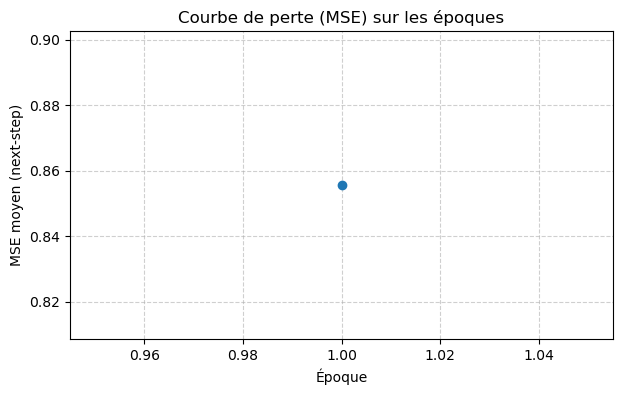

In [97]:
plt.figure(figsize=(7,4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o', linewidth=2)
plt.title("Courbe de perte (MSE) sur les époques")
plt.xlabel("Époque")
plt.ylabel("MSE moyen (next-step)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [98]:
def visualize_h(field_pred, field_true, sample_idx=0, symmetric=False):
    """
    Affiche GT vs Pred avec la même échelle de couleurs.
    - symmetric=True force une échelle [-M, M] (utile si les champs sont centrés).
    """
    pred = field_pred[sample_idx].detach().cpu().numpy()  # (T, N)
    true = field_true[sample_idx].detach().cpu().numpy()  # (T, N)

    if symmetric:
        vmax = max(np.abs(pred).max(), np.abs(true).max())
        vmin = -vmax
    else:
        vmin = min(pred.min(), true.min())
        vmax = max(pred.max(), true.max())

    plt.figure(figsize=(12, 5))

    # Ground truth
    plt.subplot(1, 2, 1)
    plt.imshow(true, aspect='auto', cmap='viridis', origin='lower',
               vmin=vmin, vmax=vmax)
    plt.colorbar(label='u(x,t) (GT)')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('True Trajectories')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(pred, aspect='auto', cmap='viridis', origin='lower',
               vmin=vmin, vmax=vmax)
    plt.colorbar(label='u(x,t) (Pred)')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('Predicted Trajectories')

    plt.tight_layout()
    plt.show()


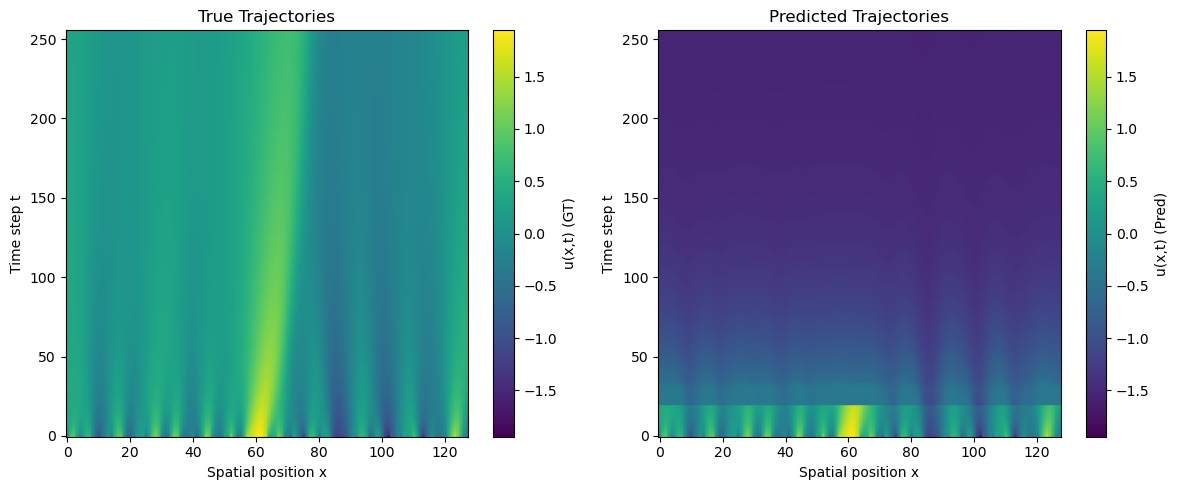

CNNController(
  (conv1): Conv1d(20, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (act1): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (act2): ReLU()
  (spatial_reduce): AdaptiveAvgPool1d(output_size=1)
  (output_layer): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
)

In [99]:
def rollout_autoregressive(model, full_trajectory, history_len, r, patch_size, sample_limit=None):
    """
    full_trajectory: (B, T, N) avec les vraies données (utilisées juste pour warm-up/visualisation).
    retourne predictions: (B, T, N)
    """
    model.eval()
    with torch.no_grad():
        B, T, N = full_trajectory.shape
        device = full_trajectory.device
        if sample_limit is not None:
            B = min(B, sample_limit)
            full_trajectory = full_trajectory[:B]

        preds = torch.zeros((B, T, N), device=device)
        # warm-up: copier GT sur les L premiers pas
        preds[:, :history_len, :] = full_trajectory[:, :history_len, :]

        # fenêtre (B, L, N)
        window = preds[:, :history_len, :].clone()

        for t in range(history_len, T):
            patches_input = build_patches_from_sequence(window, r, patch_size)  # (B*N, L, patch)
            next_pred = model(patches_input).reshape(B, N)                      # (B, N)
            preds[:, t, :] = next_pred

            # glisse la fenêtre : retire le plus ancien, ajoute la pred
            window = torch.cat([window[:, 1:, :], next_pred.unsqueeze(1)], dim=1)

    model.train()
    return preds

# Utilisation :
cnn_controller.eval()
with torch.no_grad():
    for initial_field, full_trajectory, nu in dataloader:
        B, N = initial_field.shape
        T = full_trajectory.shape[1]
        device = initial_field.device

        predictions = rollout_autoregressive(
            model=cnn_controller,
            full_trajectory=full_trajectory.to(device),
            history_len=HISTORY_LEN,
            r=r,
            patch_size=patch_size,
            sample_limit=1  # affiche juste un batch si tu veux
        )

        visualize_h(predictions, full_trajectory.to(device), sample_idx=0, symmetric=True)

        break
cnn_controller.train()